In [1]:
import warnings
import torch
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from types import SimpleNamespace
from datasets import load_dataset
from timm.optim import Mars
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent
from autocodec.evit import EfficientVitLargeStageND
from torchvision.transforms.v2 import (
    Compose, RandomCrop, CenterCrop, 
    PILToTensor, ToDtype, MixUp, ToPILImage
)
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor
from fastprogress.fastprogress import master_bar, progress_bar
import copy
import PIL.Image
import gc

In [2]:
torch.set_float32_matmul_precision('highest')
device = "cuda:0"
dataset_train = load_dataset('danjacobellis/inet1k_compressed_384', split='train')
dataset_valid = load_dataset('danjacobellis/inet1k_compressed_384', split='validation')

Resolving data files:   0%|          | 0/51 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/51 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/51 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/51 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/51 [00:00<?, ?it/s]

In [3]:
config = SimpleNamespace()
config.epochs = 100
config.batch_size = 64
config.steps_per_epoch = dataset_train.num_rows // config.batch_size
config.total_steps = config.epochs * config.steps_per_epoch

config.num_workers = 32
config.grad_accum_steps = 1
config.max_lr = 5e-5 * (config.batch_size/128)
config.min_lr = config.max_lr/1e6;
config.lr_pow = 6; assert (config.lr_pow/2)%1 == 0

config.weight_decay = 0.1
config.no_wd_keys = ['norm', 'bias']

config.progressive_sizes = [22,24]
print(config.progressive_sizes)

config.mixup_alpha = 1.0
config.label_smoothing = 0.1

config.mesa = True
config.ema_decay = 0.999
config.mesa_ratio = 2.0
config.mesa_start = 0.25

config.channels=12
config.classifier_num_classes=1000

config.log_filename = 'log'
config.checkpoint = "inet1k_compressed_384_91e.pth"

[22, 24]


In [4]:
from timm.models.efficientvit_mit import EfficientVitLarge, GELUTanh
from autocodec.evit import GroupNorm8

model = EfficientVitLarge(
    in_chans=config.channels,
    widths=(256, 256, 256, 256, 512),
    depths=(1, 1, 1, 1, 8),
    head_dim=32,
    norm_layer=GroupNorm8,
    act_layer=GELUTanh,
    global_pool='avg',
    head_widths=(3072, 3200),
    drop_rate=0.0,
    num_classes=config.classifier_num_classes
)
model.stem.in_conv.conv = torch.nn.Conv2d(12,256, kernel_size=1, stride=1, bias=False)
model.stages = torch.nn.Sequential(model.stages[3])
model.head.in_conv.norm = torch.nn.GroupNorm(
    num_groups=8,
    num_channels=model.head.in_conv.norm.num_features,
    affine=model.head.in_conv.norm.affine,
    eps=model.head.in_conv.norm.eps
)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,map_location='cpu', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)

print(sum(p.numel() for p in model.parameters())/1e6)
for name, module in model.named_children():
    print(f"{sum(p.numel() for p in module.parameters())/1e6} \t {name}")


57.226984
1.184256 	 stem
41.42592 	 stages
14.616808 	 head


In [5]:
param_groups = []
for name, p in model.named_parameters():
    if p.requires_grad:
        use_wd = True
        for kw in config.no_wd_keys:
            if kw in name.lower():
                use_wd = False
                break
        wd_val = config.weight_decay if use_wd else 0.0
        param_groups.append({'params': [p], 'weight_decay': wd_val})

optimizer = Mars(param_groups, lr=1.0, weight_decay=0.0, caution=True)

if config.checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

In [6]:
class EMAHelper:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.teacher = copy.deepcopy(model)
        for p in self.teacher.parameters():
            p.requires_grad_(False)

    def update(self, student):
        with torch.no_grad():
            d = self.decay
            for tparam, sparam in zip(self.teacher.parameters(), student.parameters()):
                tparam.copy_(tparam * d + sparam * (1 - d))
    
    def forward(self, x):
        return self.teacher(x)

In [7]:
mixup_tfm = MixUp(alpha=config.mixup_alpha, num_classes=config.classifier_num_classes)

def get_epoch_size(epoch):
    stage_len = config.epochs // len(config.progressive_sizes)
    idx = min(epoch // stage_len, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]

def build_train_prebatch_transform(epoch):
    return Compose([
        RandomCrop(get_epoch_size(epoch)),
        PILToTensor(),
        ToDtype(torch.float32,scale=False),
    ])

def build_valid_transform():
    return Compose([
        CenterCrop(config.progressive_sizes[-1]),
        PILToTensor(),
        ToDtype(torch.float32,scale=False),
    ])
    
def train_collate_fn(batch, epoch):
    transform = build_train_prebatch_transform(epoch)
    x_list, y_list = [], []
    for sample in batch:
        latent = pil_to_latent([sample['image']], N=12, n_bits=8, C=3)[0]
        x_ = transform(latent)
        x_list.append(x_)
        y_list.append(sample['cls'])
    x = torch.stack(x_list, dim=0)
    y = torch.tensor(y_list, dtype=torch.long)
    return x, torch.nn.functional.one_hot(y, num_classes=config.classifier_num_classes)

def valid_collate_fn(batch):
    transform = build_valid_transform()
    x_list, y_list = [], []
    for sample in batch:
        latent = pil_to_latent([sample['image']], N=12, n_bits=8, C=3)[0]
        x_ = transform(latent)
        y_ = sample['cls']
        x_list.append(x_)
        y_list.append(y_)
    x = torch.stack(x_list, dim=0)
    y = torch.tensor(y_list, dtype=torch.long)
    return x, y

In [8]:
def collect_garbage(**kwargs):
    g = globals()
    for var in kwargs:
        g.pop(var, None)
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]

ema_helper = EMAHelper(model, decay=config.ema_decay) if config.mesa else None

mb = master_bar(range(config.epochs))
global_step = 0

train_losses = []
valid_accs = []

for i_epoch in mb:
    model.train()
    if ema_helper:
        ema_helper.teacher.eval()

    train_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=lambda batch: train_collate_fn(batch,i_epoch)
    )

    # Training
    pb = progress_bar(train_loader, parent=mb)
    for (x, y) in pb:
        x, y = x.to(device), y.to(device)

        (x, y) = mixup_tfm((x, y))

        if config.label_smoothing>0:
            y = (1 - config.label_smoothing) * y + config.label_smoothing / config.classifier_num_classes

        logits = model(x)
        loss = torch.nn.BCEWithLogitsLoss()(logits, y)
        if global_step % 128 == 0:
            train_losses.append(loss.item())

        if ema_helper:
            frac = i_epoch / config.epochs
            if frac >= config.mesa_start:
                with torch.no_grad():
                    teacher_out = ema_helper.teacher(x)
                teacher_prob = torch.sigmoid(teacher_out)
                student_prob = torch.sigmoid(logits)
                mesa_loss = torch.nn.functional.binary_cross_entropy(student_prob, teacher_prob)
                loss = loss + config.mesa_ratio * mesa_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0, norm_type=2.0)
        optimizer.step()

        if ema_helper:
            ema_helper.update(model)

        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        global_step += 1

    collect_garbage(x=0, y=0, loss=0, logits=0, teacher_out=0, teacher_prob=0, student_prob=0, mesa_loss=0)
    
    # Validation
    model.eval()
    correct = 0

    val_loader = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    for (xv, yv) in progress_bar(val_loader, parent=mb):
        xv, yv = xv.to(device), yv.to(device)
        with torch.no_grad():
            logits_val = model(xv)
        preds = logits_val.argmax(dim=1)
        correct += (preds == yv).sum().item()

    val_acc = correct / dataset_valid.num_rows
    valid_accs.append(val_acc)

    mb.main_bar.comment = f"Epoch={i_epoch} | Train Loss={train_losses[-1]:.4f} | Val Acc={val_acc:.4f}"

    collect_garbage(xv=0, yv=0, logits_val=0, preds=0)
    
    torch.save({
        'i_epoch': i_epoch,
        'model_state_dict': model.state_dict(),
        'ema_state_dict': ema_helper.teacher.state_dict() if ema_helper else None,
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses,
        'valid_acc': valid_accs,
        'config': vars(config),
    }, f'{config.log_filename}.pth')

In [11]:
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

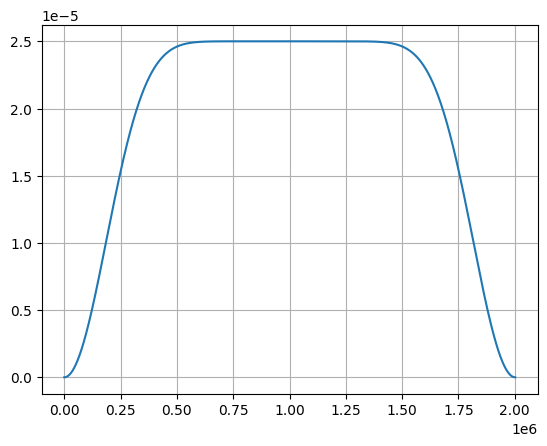

In [12]:
plt.plot(learning_rates)
plt.grid()

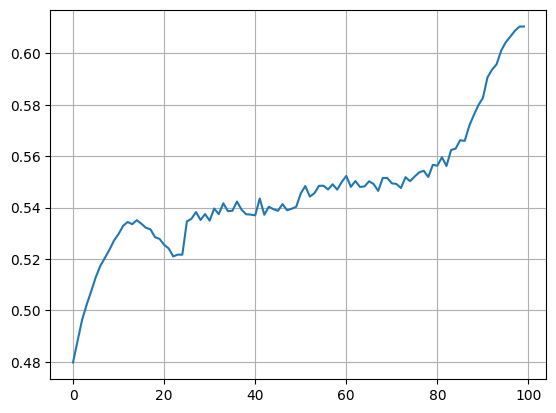

In [13]:
plt.plot(valid_accs)
plt.grid()

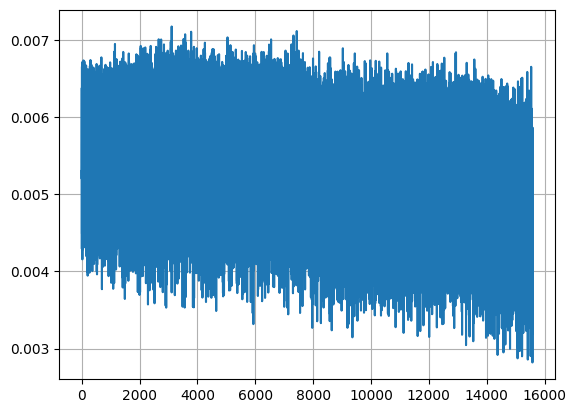

In [14]:
plt.plot(train_losses[50:])
plt.grid()

In [15]:
collect_garbage(x=0, y=0, loss=0, logits=0, teacher_out=0, teacher_prob=0, student_prob=0, mesa_loss=0)
collect_garbage(xv=0, yv=0, logits_val=0, preds=0)

In [16]:
ema_helper.teacher.eval()
        
val_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    drop_last=False,
    pin_memory=True,
    collate_fn=valid_collate_fn
)

correct = 0
for (xv, yv) in progress_bar(val_loader):
    xv, yv = xv.to(device), yv.to(device)
    with torch.no_grad():
        logits_val =  ema_helper.teacher(xv)
    preds = logits_val.argmax(dim=1)
    correct += (preds == yv).sum().item()

In [17]:
correct/dataset_valid.num_rows

0.61028

In [19]:
torch.save({
    'i_epoch': i_epoch,
    'model_state_dict': model.state_dict(),
    'ema_state_dict': ema_helper.teacher.state_dict() if ema_helper else None,
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'valid_acc': valid_accs,
    'config': vars(config),
}, '../hf/dance/inet1k_compressed_384_e200.pth')